# 2 Movie embeddings (40pt)

# Co occurence

In [2]:
#import stuff here

import pandas as pd
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
#Reading data
ratings = pd.read_csv("/content/drive/My Drive/Fall 20/576/HWs/2/ratings.csv")
movies = pd.read_csv("/content/drive/My Drive/Fall 20/576/HWs/2/movies.csv")

#Ratings of only 4 and 5 are considered Liked 
ratings['Liked'] = np.where(ratings['rating'] >= 4, 1, 0)

#Dropping unnecessary columns
ratings = ratings.drop(labels=['rating', 'timestamp'], axis= 1)

In [8]:
#Intializing co-occurence matrix with zeros
coOccur_dim = ratings['movieId'].nunique()
coOccurence = pd.DataFrame(np.zeros(shape=(coOccur_dim,coOccur_dim)))

unique_movieId = ratings['movieId'].unique()
coOccurence = coOccurence.set_index(unique_movieId)
coOccurence.columns = unique_movieId

In [9]:
ratings = ratings[ratings['Liked'] == 1]
ratings = ratings.drop('Liked', axis = 1) 

In [10]:
unique_userId = ratings['userId'].unique()

In [11]:
#Creating a hash-map with movie Id as key and list of liked movies as values
user_movies = {u: 0 for u in unique_userId}
for user in user_movies:
    #print(user_movies[user])
    user_movies[user] = list(ratings[ratings['userId'] == user]['movieId'])

In [ ]:
#FOund the co-occurence values from above hash-map
#Bottom triangle kept empty no need to repeat values
#Number of users liked movied (1,3) is same as (3,1) {movie liked -> ratings of 4 or 5}
'''
for user in user_movies:
    for i in range(len(user_movies[user])):
        #print(user_movies[user][i])
        for j in range(i+1, len(user_movies[user])):
          #print('j:', j)
            #print(user_movies[user][j])
            coOccurence.loc[(user_movies[user][i]), (user_movies[user][j])] += 1
            #print(user_movies[user][j])
'''   
#Pickle file saved    
    
        

In [ ]:
coOccurence

,1,3,6,47,50,70,101,110,151,157,163,216,223,231,235,260,296,316,333,349,356,362,367,423,441,457,480,500,527,543,552,553,590,592,593,596,608,648,661,673,...,113565,113780,113862,114044,114670,114707,115727,117867,118082,128838,129313,130050,130052,130840,133832,135534,135803,135815,138610,138632,139511,139655,140267,141400,141799,142366,142598,145951,146309,147657,147662,148166,149011,152372,158721,160341,160527,160836,163937,163981
1,0.0,12.0,28.0,49.0,58.0,11.0,8.0,56.0,11.0,3.0,14.0,10.0,21.0,17.0,21.0,79.0,74.0,13.0,11.0,18.0,82.0,7.0,26.0,1.0,15.0,53.0,65.0,28.0,60.0,11.0,8.0,19.0,41.0,27.0,73.0,22.0,58.0,33.0,16.0,8.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,5.0,9.0,5.0,1.0,3.0,11.0,5.0,3.0,3.0,4.0,4.0,6.0,4.0,9.0,6.0,6.0,7.0,6.0,12.0,3.0,7.0,0.0,4.0,11.0,10.0,7.0,7.0,4.0,5.0,8.0,10.0,5.0,11.0,4.0,6.0,6.0,5.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,40.0,37.0,14.0,4.0,43.0,7.0,2.0,13.0,4.0,15.0,10.0,14.0,42.0,46.0,10.0,9.0,14.0,42.0,5.0,10.0,1.0,9.0,32.0,32.0,9.0,32.0,4.0,5.0,11.0,21.0,15.0,48.0,7.0,37.0,20.0,5.0,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
47,0.0,0.0,0.0,0.0,76.0,20.0,8.0,71.0,13.0,3.0,16.0,8.0,30.0,19.0,18.0,70.0,112.0,19.0,13.0,22.0,87.0,8.0,24.0,0.0,17.0,52.0,55.0,20.0,69.0,10.0,9.0,20.0,45.0,30.0,103.0,18.0,60.0,29.0,9.0,4.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
50,0.0,0.0,0.0,0.0,0.0,19.0,10.0,64.0,12.0,4.0,14.0,7.0,36.0,17.0,27.0,82.0,124.0,18.0,12.0,15.0,89.0,8.0,21.0,0.0,14.0,50.0,48.0,15.0,86.0,12.0,7.0,17.0,43.0,32.0,101.0,17.0,73.0,27.0,8.0,3.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

pickle.dump(coOccurence,open('/content/drive/My Drive/Fall 20/576/HWs/2/X.pickle','wb'))

In [3]:
#Reading a co-occurence matrix from pickle file
coOccurenceFile = open("/content/drive/My Drive/Fall 20/576/HWs/2/X.pickle",'rb')
coOccurence = pickle.load(coOccurenceFile)

In [4]:
#Normalizing co-occurence vales so cost function values don't become too high
coOccurence = coOccurence / coOccurence.values.max()

,1,3,6,47,50,70,101,110,151,157,163,216,223,231,235,260,296,316,333,349,356,362,367,423,441,457,480,500,527,543,552,553,590,592,593,596,608,648,661,673,...,113565,113780,113862,114044,114670,114707,115727,117867,118082,128838,129313,130050,130052,130840,133832,135534,135803,135815,138610,138632,139511,139655,140267,141400,141799,142366,142598,145951,146309,147657,147662,148166,149011,152372,158721,160341,160527,160836,163937,163981
0,0.0,1.0,1.000000,0.907407,0.763158,0.55,0.8,0.788732,0.578947,0.75,0.70,0.833333,0.583333,0.772727,0.777778,0.963415,0.596774,0.433333,0.647059,0.486486,0.488095,0.538462,0.764706,1.0,0.833333,0.616279,0.656566,0.636364,0.465116,0.785714,0.5000,0.633333,0.539474,0.675,0.480263,1.000000,0.591837,0.702128,1.0000,1.000,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.178571,0.166667,0.065789,0.05,0.3,0.154930,0.263158,0.75,0.15,0.333333,0.111111,0.272727,0.148148,0.109756,0.048387,0.200000,0.411765,0.162162,0.071429,0.230769,0.205882,0.0,0.222222,0.127907,0.101010,0.159091,0.054264,0.285714,0.3125,0.266667,0.131579,0.125,0.072368,0.181818,0.061224,0.127660,0.3125,0.250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.740741,0.486842,0.70,0.4,0.605634,0.368421,0.50,0.65,0.333333,0.416667,0.454545,0.518519,0.512195,0.370968,0.333333,0.529412,0.378378,0.250000,0.384615,0.294118,1.0,0.500000,0.372093,0.323232,0.204545,0.248062,0.285714,0.3125,0.366667,0.276316,0.375,0.315789,0.318182,0.377551,0.425532,0.3125,0.250,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,1.000000,1.00,0.8,1.000000,0.684211,0.75,0.80,0.666667,0.833333,0.863636,0.666667,0.853659,0.903226,0.633333,0.764706,0.594595,0.517857,0.615385,0.705882,0.0,0.944444,0.604651,0.555556,0.454545,0.534884,0.714286,0.5625,0.666667,0.592105,0.750,0.677632,0.818182,0.612245,0.617021,0.5625,0.500,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.000000,0.95,1.0,0.901408,0.631579,1.00,0.70,0.583333,1.000000,0.772727,1.000000,1.000000,1.000000,0.600000,0.705882,0.405405,0.529762,0.615385,0.617647,0.0,0.777778,0.581395,0.484848,0.340909,0.666667,0.857143,0.4375,0.566667,0.565789,0.800,0.664474,0.772727,0.744898,0.574468,0.5000,0.375,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9720,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,...,0.

# Model

In [55]:
dot = torch.empty(len(unique_movieId), len(unique_movieId))
lr = [0.1, 0.5, 0.9]
loss_list1 = [] #Lr[0]
loss_list2 = [] #LR[1]
loss_list3 = [] #LR[2]


for l in lr:
    #Intializing vector embedding with standard normal distribution
    #300 feaures chosen, 300 seems big enough for movie (Director, actors, etc...)

    #Adam optimizer
    embedding = torch.randn(len(unique_movieId), 300, device=device, requires_grad=True)
    optimizer = torch.optim.Adam([embedding], l)

    for epoch in range(3000):
        dot = torch.matmul(embedding, torch.transpose(embedding, 0, 1 ))

        loss = (dot - torch.tensor(coOccurence.values, device=device, requires_grad=False)) ** 2
        loss = torch.triu(loss, diagonal=1) #Setting lower traingle to 0
        loss = torch.sum(loss)

        
        
        if (epoch % 100 == 0):            
            print("epoch: ", epoch, "loss: ", float(loss))

            if (l == 0.1):
                loss_list1.append(loss)
            elif (l == 0.5):
                loss_list2.append(loss)
            elif (l == 0.9):
                loss_list3.append(loss)


        loss.backward()

        #Adam optimizer
        optimizer.step()
        optimizer.zero_grad()

        #Simple batch gradient descent 
        '''
        with torch.no_grad():
            embedding -= l * embedding.grad
            
            # Manually zero the gradients after updating weights
            embedding.grad.zero_()
        '''
#learning rate = 0.00001 and regualr GD after 3000 epoch - loss -> 11,200 
#leaning rate = 0.00005 and regular GD after 3000 epoch - loss -> 619 
#leaning rate = 0.00007 and regular GD after 3000 epoch - loss -> 400 

#learning rate = 0.1 and Adam after 3000 epoch - loss -> 450
#learning rate = 0.5 and Adam after 3000 epoch - loss -> 2
#learning rate = 0.9 and Adam after 3000 epoch - loss -> 1

epoch:  0 loss:  14181642843.535324
epoch:  100 loss:  2036175.5922936047
epoch:  200 loss:  486906.1604819143
epoch:  300 loss:  207017.15125825274
epoch:  400 loss:  109217.97825673388
epoch:  500 loss:  64885.63848249526
epoch:  600 loss:  41608.08585551314
epoch:  700 loss:  28159.01054633243
epoch:  800 loss:  19842.903662033747
epoch:  900 loss:  14431.45378782336
epoch:  1000 loss:  10766.377660556427
epoch:  1100 loss:  8202.504166693823
epoch:  1200 loss:  6360.333532620001
epoch:  1300 loss:  5006.533228696528
epoch:  1400 loss:  3992.2659324292526
epoch:  1500 loss:  3219.5901534669515
epoch:  1600 loss:  2622.3103686018603
epoch:  1700 loss:  2154.6349036446436
epoch:  1800 loss:  1784.2333945540522
epoch:  1900 loss:  1487.862671990105
epoch:  2000 loss:  1248.5404409469375
epoch:  2100 loss:  1053.6772411195905
epoch:  2200 loss:  893.8168851992924
epoch:  2300 loss:  761.7713421309188
epoch:  2400 loss:  652.0169528760703
epoch:  2500 loss:  560.2664693787492
epoch:  260

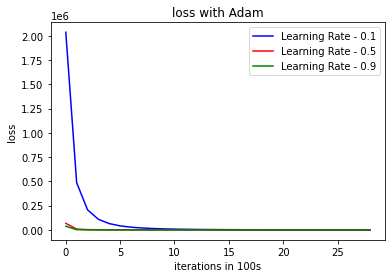

In [57]:
#Plotting loss for variety of learning rates

#Not plotting first value of loss, since it's too big and overwhelms other values
plt.plot(loss_list1[1:], 'b-', label = 'Learning Rate - 0.1')
plt.plot(loss_list2[1:], 'r-', label = 'Learning Rate - 0.5')
plt.plot(loss_list3[1:], 'g-', label = 'Learning Rate - 0.9')
plt.xlabel('iterations in 100s')
plt.ylabel('loss')
plt.legend(loc = 'upper right')
plt.title('loss with Adam')
plt.show()

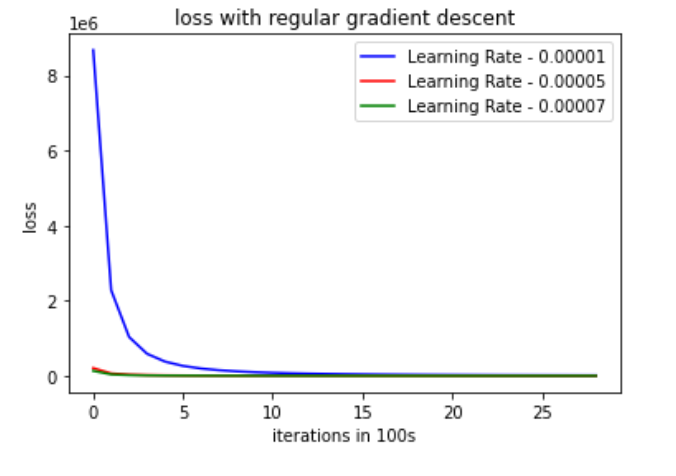

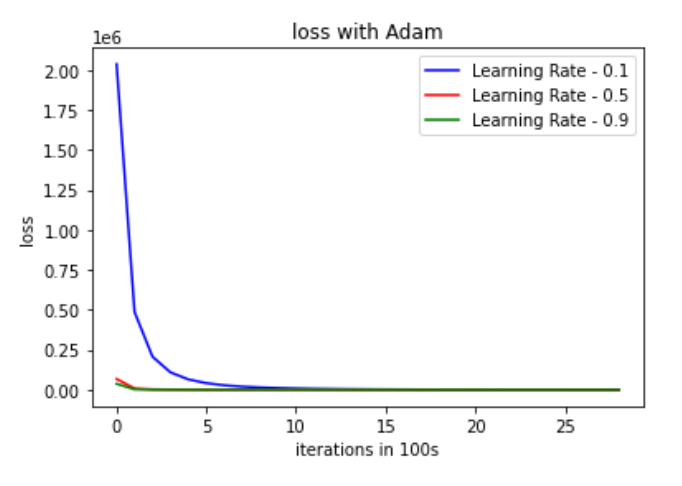

In [28]:
#Normalizing embedding to values from 0 to 1
embedding = embedding.view(embedding.size(0), -1)
embedding -= embedding.min(1, keepdim=True)[0]
embedding /= embedding.max(1, keepdim=True)[0]

#Re-calculating dot product from final embeddings to use to find similarities (cosine)
dot = torch.matmul(embedding, torch.transpose(embedding, 0, 1 ))

In [29]:
#Hash-map where key is movieId and values is list of norm of that movie embedding and index of that movie
embedding_norms = {movieId: [float(torch.norm(embedding[i])), i] for i, movieId in enumerate(unique_movieId)}


In [ ]:
#sim1_6 = dot[embedding_norms[153][1]][embedding_norms[592][1]] / (embedding_norms[153][0] * embedding_norms[592][0])

In [51]:
#Enter the movie name, we will return similar great movies that people liked(rating >= 4) 
user_movieId = movies[movies['title'].str.contains('Home Alone')]


In [52]:
user_movieId

,movieId,title,genres
504,586,Home Alone (1990),Children|Comedy
1285,1707,Home Alone 3 (1997),Children|Comedy
2224,2953,Home Alone 2: Lost in New York (1992),Children|Comedy
8625,118880,"Girl Walks Home Alone at Night, A (2014)",Horror|Romance|Thriller


In [53]:
#Using the userid of movie provided, calculating cosine similarity between embeddings and printing top 10
user_movieId = 586
sim_score = []

for i in unique_movieId:
    if i == user_movieId:
        continue

    sim = dot[embedding_norms[user_movieId][1]][embedding_norms[i][1]] / (embedding_norms[user_movieId][0] * embedding_norms[i][0])
    sim_score.append([float(sim), i])

sim_score.sort(reverse = True)
similar = pd.DataFrame(sim_score[0:10])
similar_movieIds = pd.DataFrame(similar[1])
similar_movieIds.columns = ['movieId']
final = similar_movieIds.merge(movies, how = "left", on='movieId')

In [54]:
final.drop('movieId', axis=1)

,title,genres
0,Outpost (2008),Action|Horror
1,Prime Suspect 3 (1993),Crime|Drama|Mystery
2,"McFarland, USA (2015)",Drama
3,Fast Times at Ridgemont High (1982),Comedy|Drama|Romance
4,"Bad Seed, The (1956)",Drama|Thriller
5,Indie Game: The Movie (2012),Documentary
6,Premium Rush (2012),Action|Thriller
7,Brainstorm (2001),Drama
8,Hot Fuzz (2007),Action|Comedy|Crime|Mystery
9,"French Connection, The (1971)",Action|Crime|Thriller


The recommendation chnages based on Learning rate beacuase with different learning rates we're getting different embedding values. So when we find cosine similarity between those different movies are coming up on Top 10. 

However with learning rate of 0.00005 and 0.00007, loss comes very similar so embeddings and so the recommendaton. But there's a little variation in the ordering of the recommendation

## Below are the recommendation based on co-occurence of ratings ( rating of 4 and 5 meant user liked the movie) This recommendation is not based on similarity of movies. First, movie has to be good (rating of 4 or 5) and co-occurence value (number of people liking both movie together) also have to high to come up in recommendation.

# Batch Gradient Descent Recommendation

Top 10: Recommended movies Toy Story (Regular GD, LR = 0.00001)

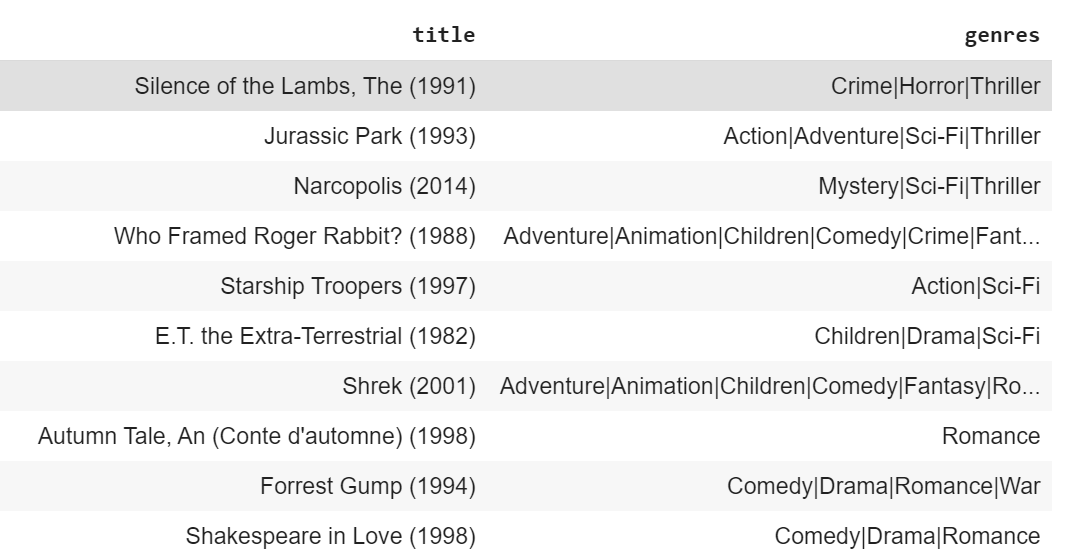

Top 10: Similar movies Apollo 13 (Regular GD, LR = 0.00001)

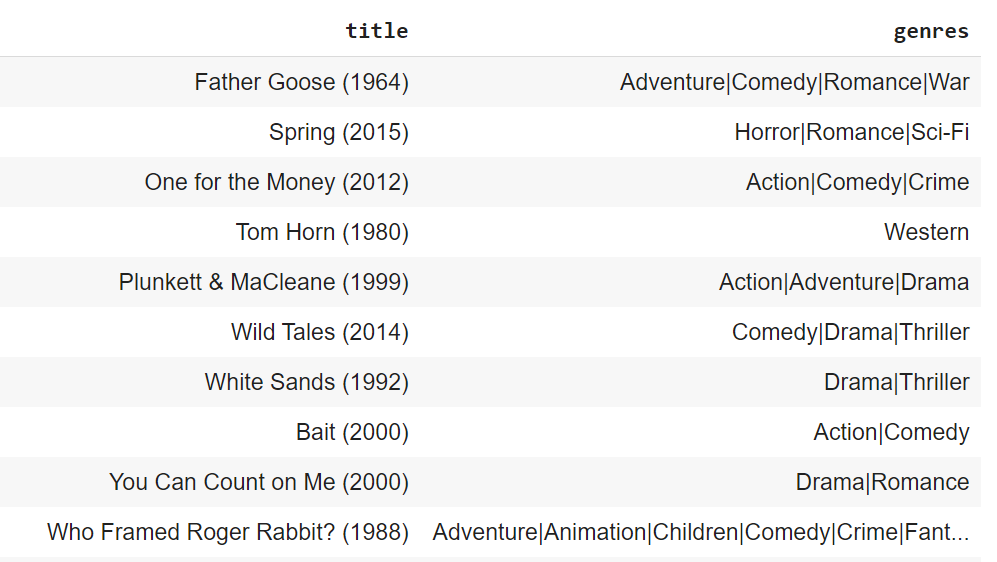

Top 10: Similar movies Home Alone (Regular GD, LR = 0.00001)

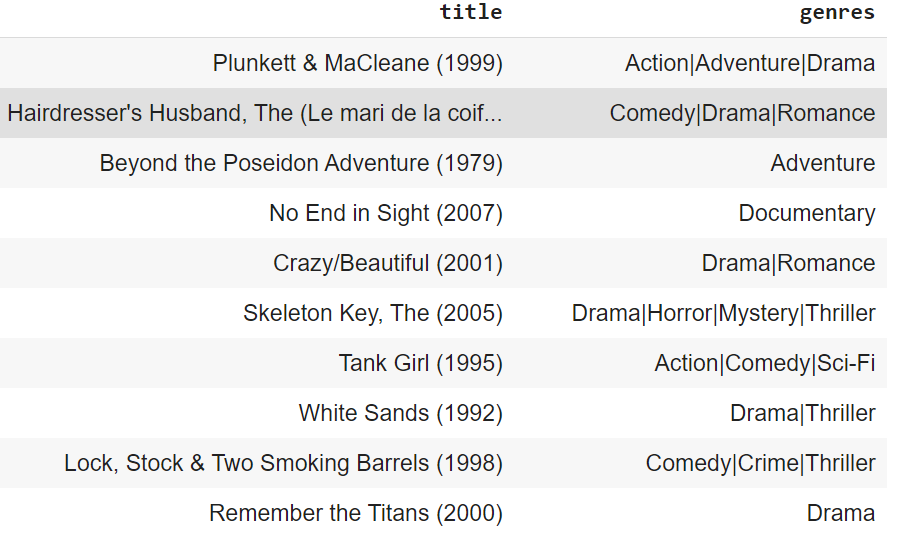



---
Top 10: Recommended movies Home Alone (Regular GD, LR = 0.00005)

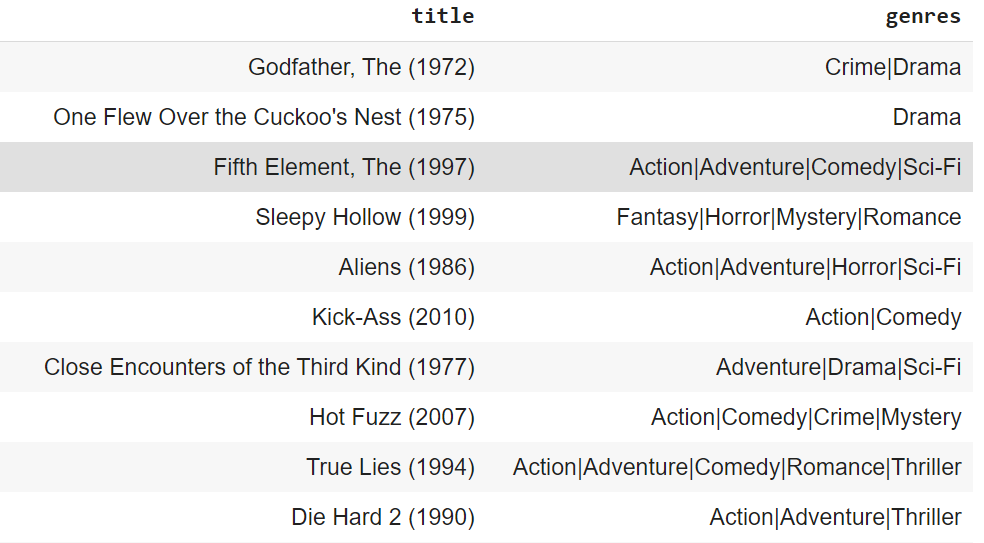


Top 10: Recommended movies Apollo 13 (Regular GD, LR = 0.00005)

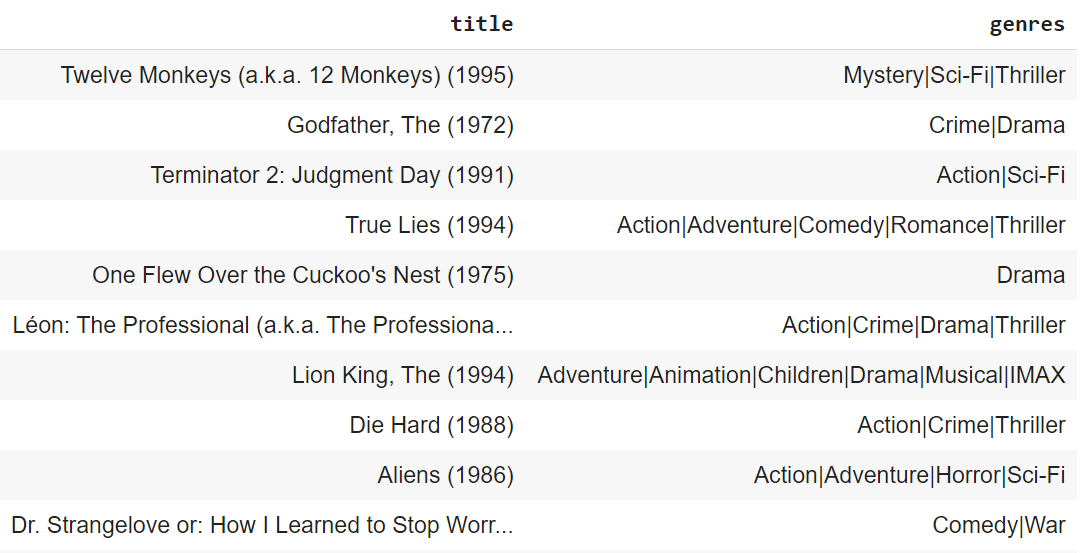

Top 10: Recommended movies Toy Story (Regular GD, LR = 0.00005)

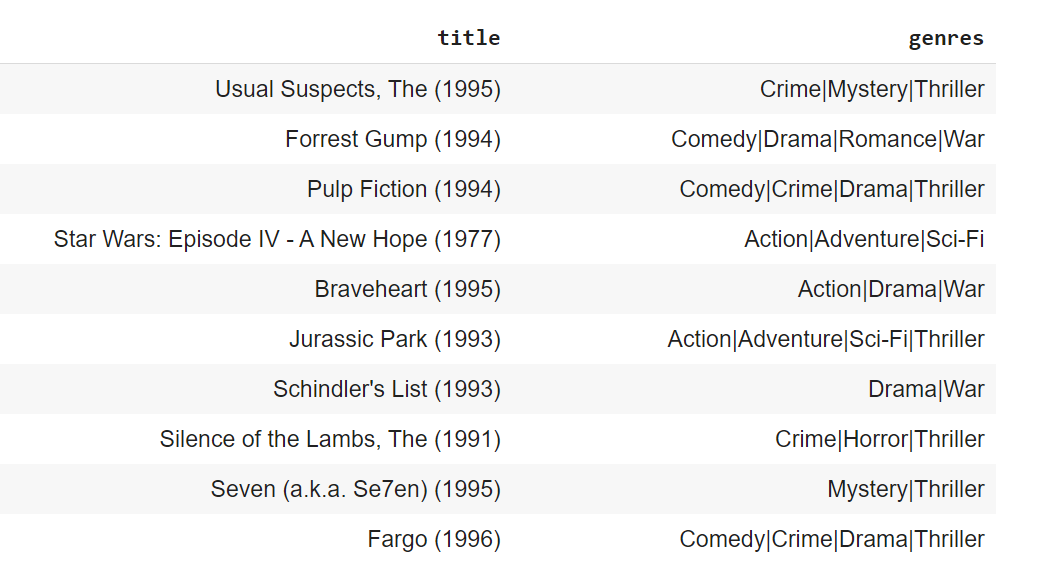



---
Top 10: Recommended movies Toy Story (Regular GD, LR = 0.00007)

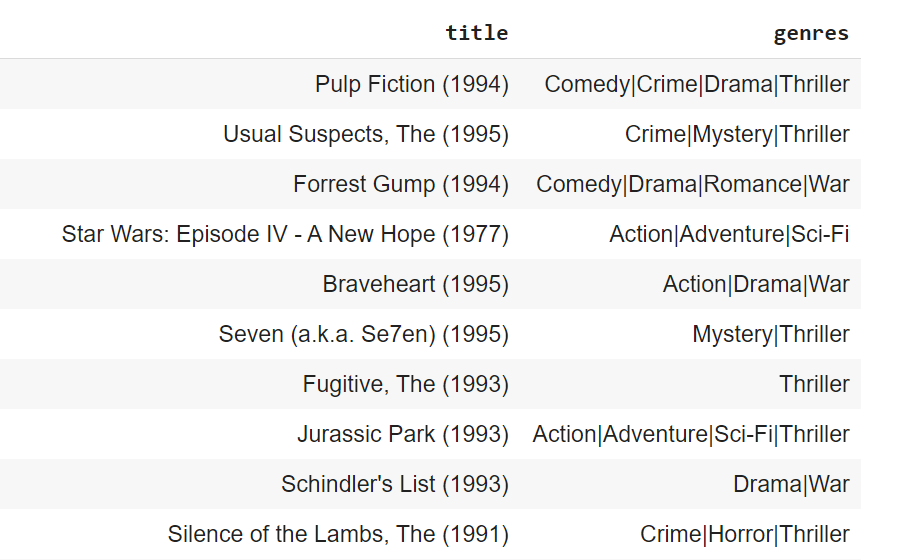


Top 10: Recommended movies Apollo 13 (Regular GD, LR = 0.00007)

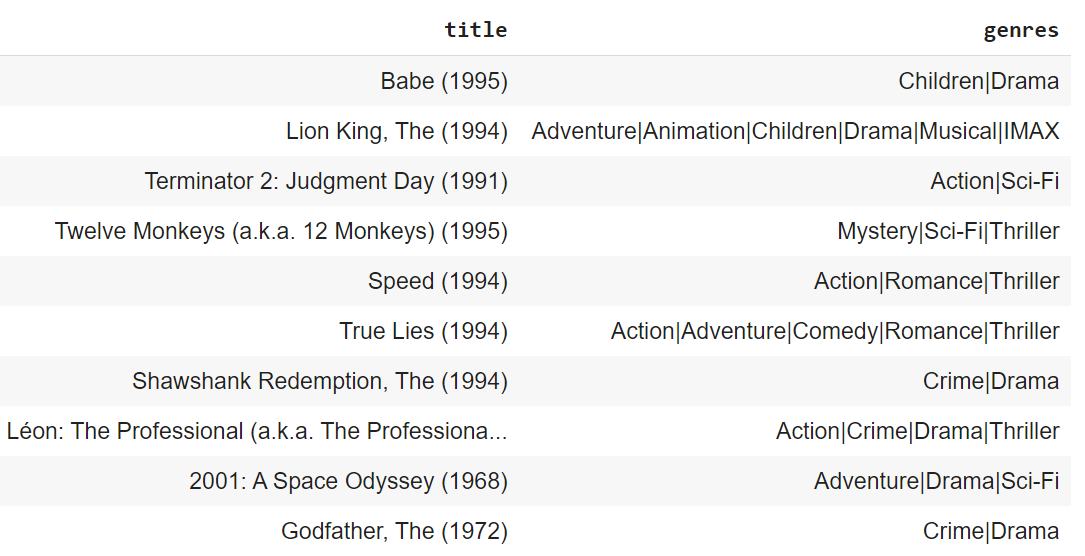

Top 10: Recommended movies Home Alone (Regular GD, LR = 0.00007)

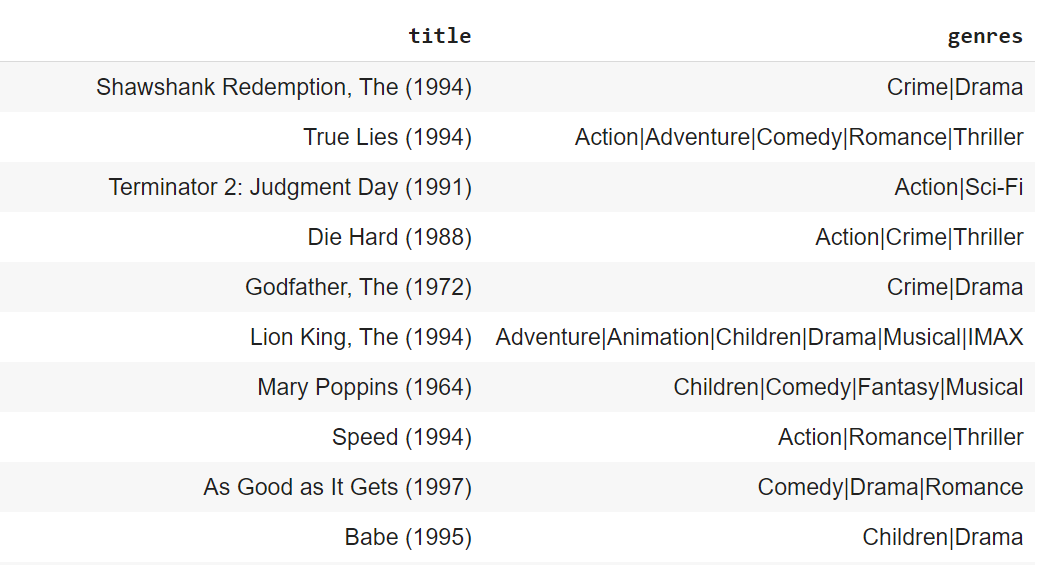

# Adam Recommendation



Top 10: Recommended movies Home Alone (Adam, LR = 0.1)

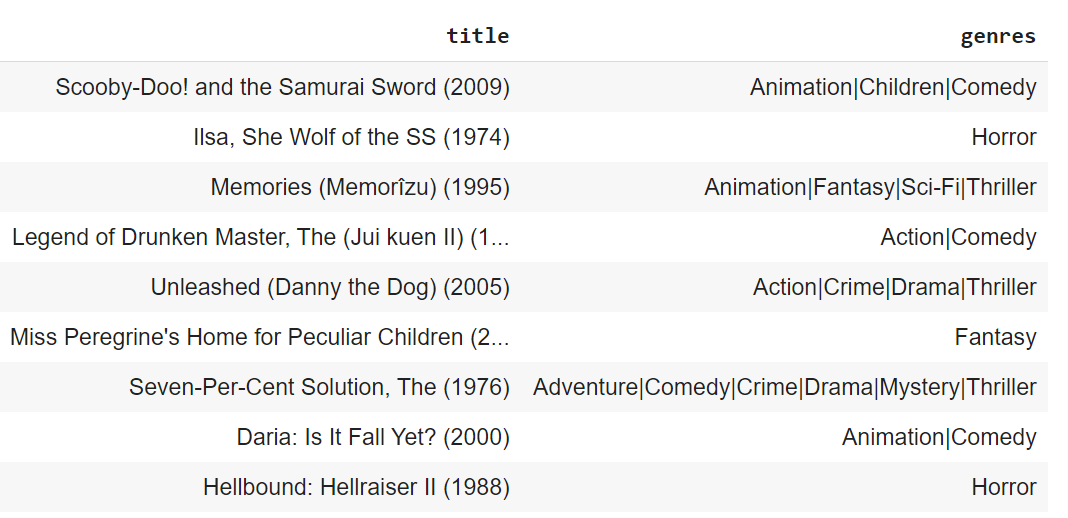



---
Top 10: Recommended movies Home Alone (Adam, LR = 0.5)

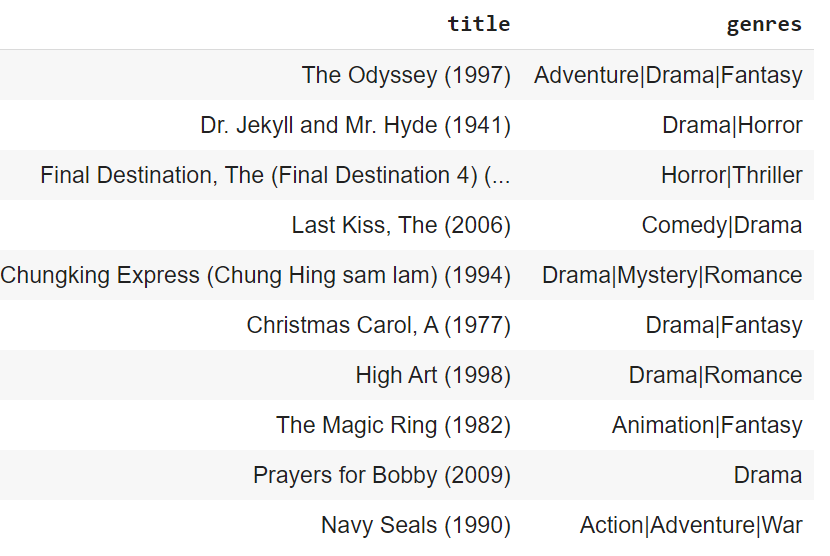


Top 10: Recommended movies Apollo 13 (Adam, LR = 0.5)

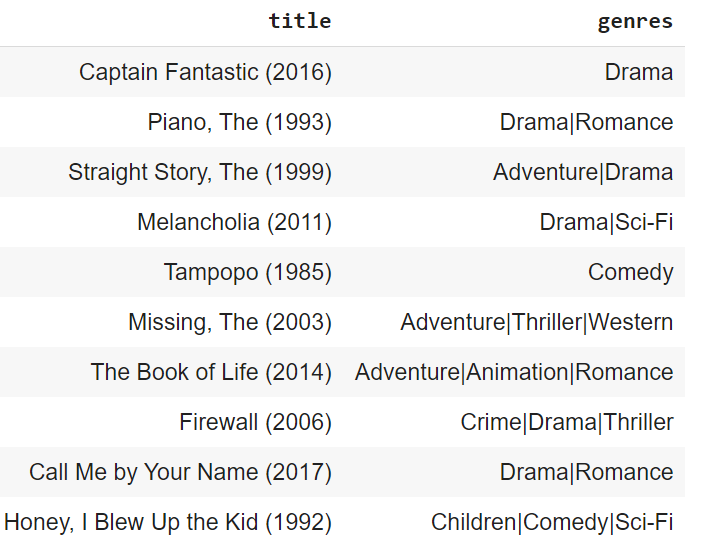

Top 10: Recommended movies Toy Story (Adam, LR = 0.5)

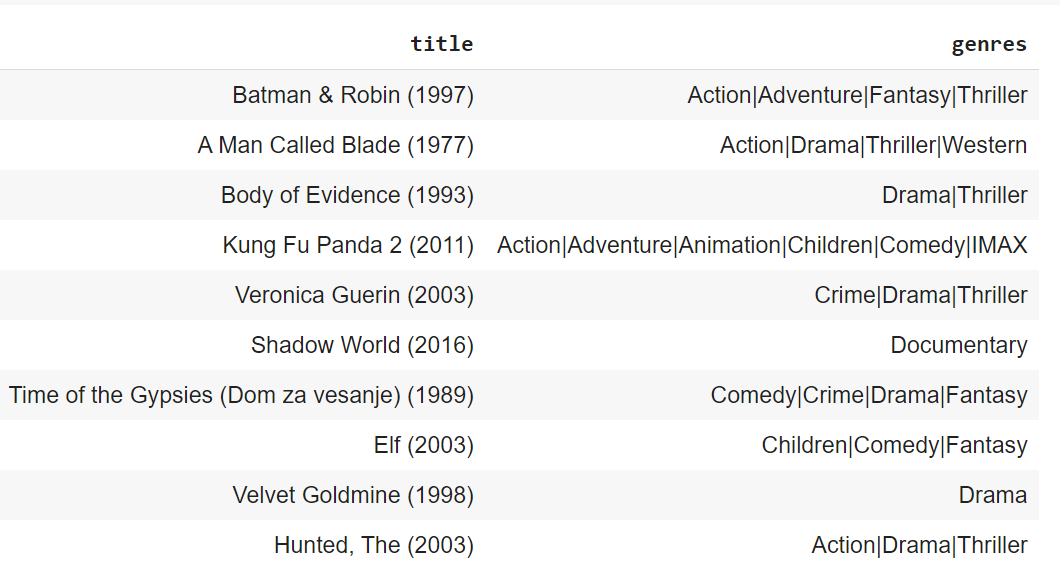



---
Top 10: Recommended movies Toy Story (Adam, LR = 0.9)

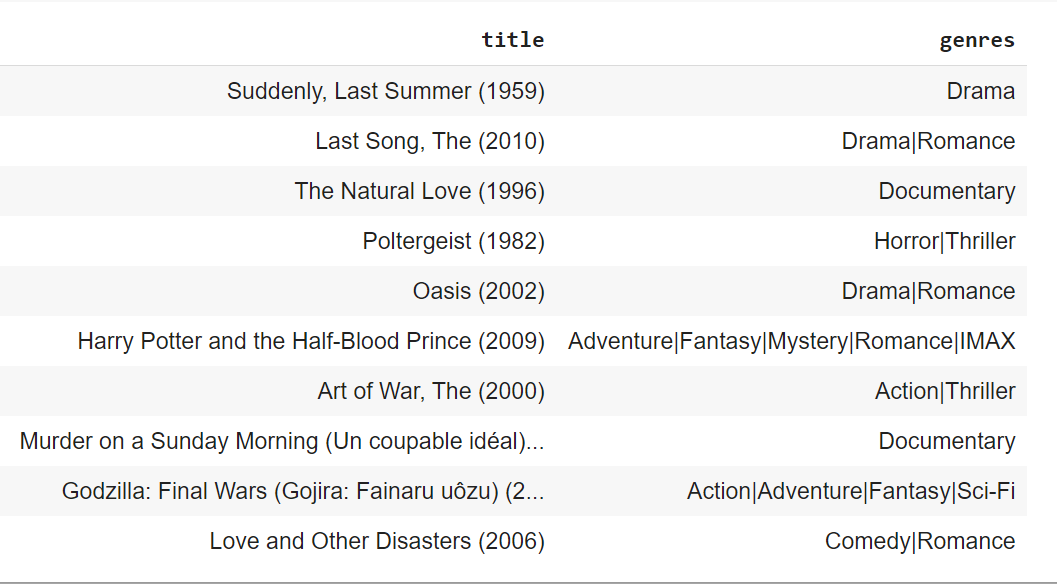


Top 10: Recommended movies Apollo 13 (Adam, LR = 0.9)

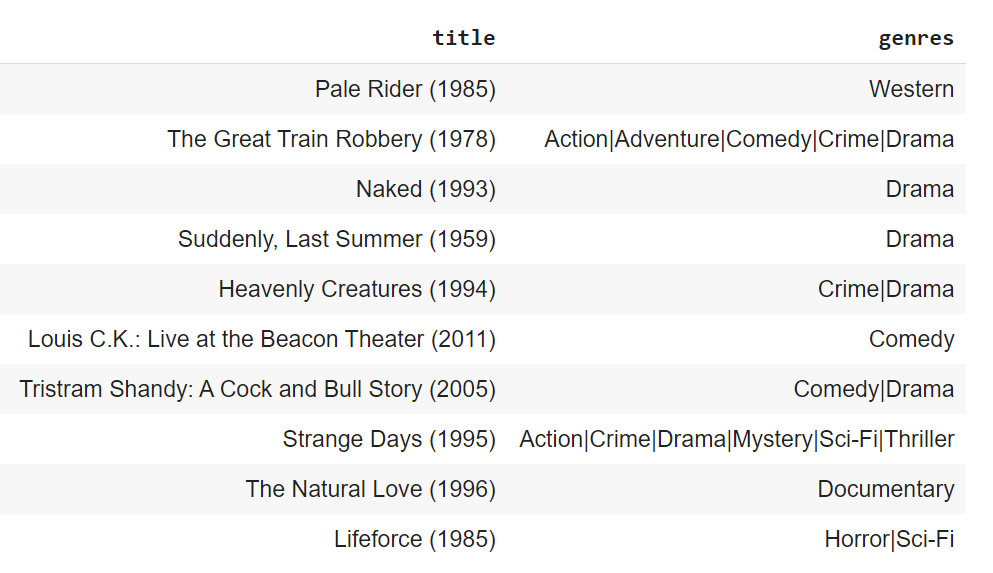

Top 10: Recommended movies Home Alone (Adam, LR = 0.9)

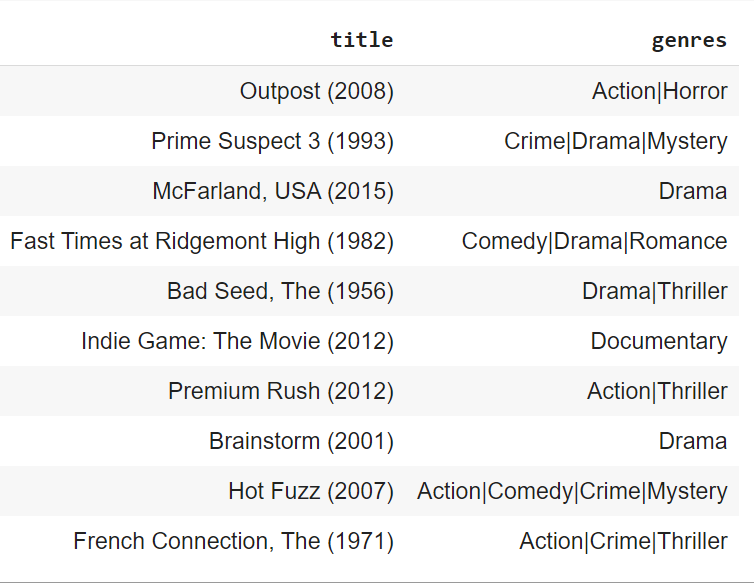